In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import os

import matplotlib.pyplot as plt

In [5]:
US_pop = {
    "AL": 4903185,"AK": 731545,
    "AZ": 7278717,"AR": 3017852,
    "CA": 39512223,"CO": 5758736,
    "CT": 3565287,
    "DE": 973764,"FL": 21477737,
    "GA": 10617423,"HI": 1415872,
    "ID": 1787065,"IL": 12671821,
    "IN": 6732219,"IA": 3155070,
    "KS": 2913314,"KY": 4467673,
    "LA": 4648794,
    "ME": 1344212,"MD": 6045680,
    "MA": 6949503,"MI": 9986857,
    "MN": 5639632,"MS": 2976149,
    "MO": 6137428,"MT": 1068778,
    "NE": 1934408,
    "NV": 3080156,"NH": 1359711,
    "NJ": 8882190,"NM": 1096829,
    "NY": 19453561,"NC": 10488084,
    "ND": 762062,"OH": 11689100,
    "OK": 3956971,"OR": 4217737,
    "PA": 12801989,"RI": 1059361,
    "SC": 5148714,"SD": 884659,
    "TN": 6833174,"TX": 28995881,
    "UT": 3205958,
    "VT":623989,"VA": 8535519,
    "WA": 8614893,"WV": 1792147,
    "WI": 5822434,
    "WY":578759,"DC":705749
}

def map_state(state):
    """ Map state into region """
    US_region = {
        "northeast": ["CT", "ME", "MA", "NH", "RI", "VT", "NJ", "NY", "PA"],
        "midwest": ["IL", "IN", "MI", "TN", "IA", "KS", "MN", "OH", "MO", "NE", "ND", "SD", "WI"],
        "south" : ["DE", "FL", "GA", "MD", "NC", "SC", "VA", "DC", "WV", "AL", "KY", "MS", "TN", "AR", "LA", "OK", "TX"],
        "west" : ["AZ", "CO", "ID", "MT", "NV", "NM", "UT", "WY", "AK", "CA", "HI", "OR", "WA"]
    }
    for key, items in US_region.items():
        if state in items:
            return key

def is_highway(street):
    
    
    """ map street into highway/non-highway """
    states = list(US_pop.keys())
    s = street.split(" ")
    
    if "I-" in s[0]:
        return True
    if "Freeway" in s[-1]:
        return True
    if "US-" in s[0]:
        return True
    if s[-1].isnumeric():
        return True
    if "Highway" in s:
        return True
    if "Freeway" in s:
        return True
    if "Hwy" in s:
        return True
    if "Fwy" in s:
        return True
    if "Expy" in s:
        return True
    
    for st in states:
        if "{}-".format(st) in s[0]:
            return True
    return False


def encode_weather(desc):
    """ Encode weather_condition """
    if type(desc) != float:
        if "storm" in desc.lower() or "thunder" in desc.lower() or "smoke" in desc.lower() or "tornado" in desc.lower():
            return "storm"
        elif "clear" in desc.lower() or "fair" in desc.lower():
            return "clear"
        elif "rain" in desc.lower() or "drizzle" in desc.lower():
            return "rain"
        elif "cloud" in desc.lower() or "dust" in desc.lower() or "fog" in desc.lower():
            return "cloud/dust/fog"
        elif "snow" in desc.lower() or "ice" in desc.lower():
            return "snow"
        elif "wind" in desc.lower():
            return "windy"
        else:
            return "other"
    else:
        return "other"

def filter_df(df):
    
    # eliminate inconsistent day/night
    df = df[(df["Sunrise_Sunset"].isin(["Day", "Night"])) &
       (df["Civil_Twilight"].isin(["Day", "Night"])) &
       (df["Nautical_Twilight"].isin(["Day", "Night"])) &
       (df["Astronomical_Twilight"].isin(["Day", "Night"]))
      ]

    # drop irrelevant columns
    DROP_COLS = ["Source", "Number", "Side", "Country", "End_Lat", "End_Lng", "Turning_Loop", "Precipitation(in)", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", "Airport_Code", "Weather_Timestamp", "Timezone"]
    df = df.drop(columns=DROP_COLS)
    
    # map is_highway
    df["is_highway"] = df["Street"].apply(is_highway)
    
    # create US region
    df["region"] = df["State"].apply(map_state)
    
    # create time_elapsed
    df["Time_Elapsed"] = (pd.to_datetime(df['End_Time'])-pd.to_datetime(df["Start_Time"])).astype('timedelta64[m]')
    df = df[df["Time_Elapsed"] > 0]
    
    # categorize weather_condition
    df["Weather"] = df["Weather_Condition"].apply(encode_weather)
    
    HAS_NA_COLS = ["Temperature(F)", 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)','Wind_Speed(mph)']
    
    for _c in HAS_NA_COLS:
        df.loc[df[_c].isnull(), _c] = df[_c].median()
    
    return df

# df = filter_df(df)

In [2]:
PATH = "../../../archive/US_Accidents_June20.csv"
PARENT = "../../../archive/"
filename = "US_Accidents_June20"

In [4]:
df.loc[df["Temperature(F)"].isnull(), "Temperature(F)"].head()

NameError: name 'df' is not defined

In [5]:
df[df["Distance(mi)"]>0].sum()

NameError: name 'df' is not defined

In [3]:
df = pd.read_csv(PATH)
df.shape

(3513617, 49)

In [6]:
df = filter_df(df)

In [7]:
df.shape

(3513480, 39)

In [25]:
severity_df = pd.DataFrame(df.groupby("Severity").count()["ID"])

In [26]:
severity_df["ration"] = severity_df["ID"].apply(lambda x: x/df.shape[0])

In [28]:
severity_df

,ID,ration
Severity,,
0,2402287,0.683734
1,1111193,0.316266


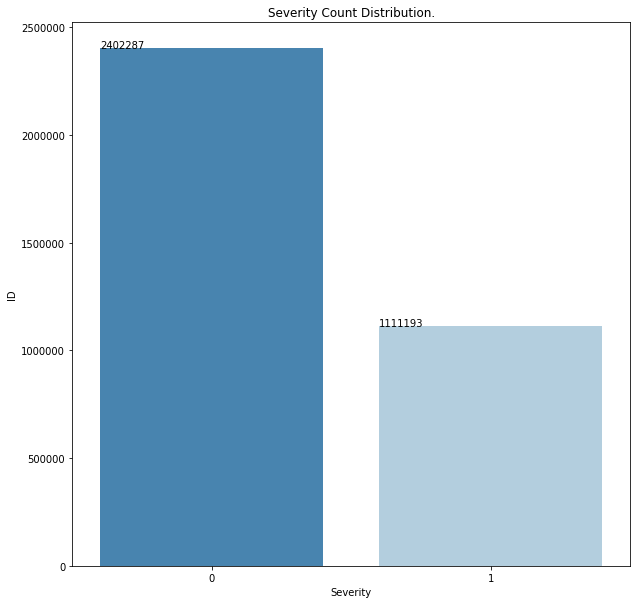

In [27]:
plt.figure(figsize=(10,10))
ax = sns.barplot(x=severity_df.index, y=severity_df["ID"], palette="Blues_r")
plt.title("Severity Count Distribution.")
# _ = plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x(), p.get_height())
    )
            

In [24]:
df["Severity"] = df["Severity"].apply(lambda x: 0 if x < 3 else 1)

In [19]:
df["Severity"].unique()

array([1, 0], dtype=int64)

In [ ]:
df["Severity"].head()

In [ ]:
df[df["TMC"] == 201.0].groupby("Severity").count()["ID"]

In [ ]:
df["Distance(mi)"]

In [8]:
df.shape

(3513480, 39)

In [25]:
df["region"].unique()

array(['midwest', 'south', 'west', 'northeast'], dtype=object)

In [33]:
df.groupby("region").count()["ID"]

region
midwest       544561
northeast     414259
south        1379967
west         1174693
Name: ID, dtype: int64

In [22]:
for region in df["region"].unique():
    df[df["region"] == region].to_csv(os.path.join(PARENT, "{}_clean_{}.csv".format(filename, region)))

In [24]:
df.to_csv(os.path.join(PARENT, "{}_clean.csv".format(filename)))

## Day VS Night

In [6]:
TWILIGHT_COLS = ["Civil_Twilight", "Sunrise_Sunset", "Nautical_Twilight", "Astronomical_Twilight"]

In [7]:
new_df = df.melt(value_vars=["Civil_Twilight", "Sunrise_Sunset", "Nautical_Twilight", "Astronomical_Twilight"])
new_df["count"] = 1
new_df.head()
twilight_count = new_df.groupby(["variable", "value"]).count()
twilight_count = twilight_count.reset_index()
del new_df

In [8]:
twilight_count

,variable,value,count
0,Astronomical_Twilight,Day,3075001
1,Astronomical_Twilight,Night,438501
2,Civil_Twilight,Day,2767921
3,Civil_Twilight,Night,745581
4,Nautical_Twilight,Day,2943398
5,Nautical_Twilight,Night,570104
6,Sunrise_Sunset,Day,2593757
7,Sunrise_Sunset,Night,919745


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

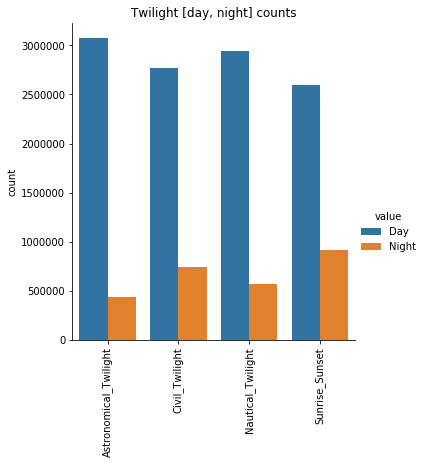

In [9]:
fg = sns.catplot(x="variable", y='count', hue="value", data=twilight_count, kind='bar')
fg.set_xlabels('')
plt.title("Twilight [day, night] counts")
plt.xticks(rotation=90)

In [10]:
df = df[(df["Sunrise_Sunset"].isin(["Day", "Night"])) &
   (df["Civil_Twilight"].isin(["Day", "Night"])) &
   (df["Nautical_Twilight"].isin(["Day", "Night"])) &
   (df["Astronomical_Twilight"].isin(["Day", "Night"]))
  ]

In [11]:
df.shape

(3513502, 49)

In [132]:
weat = df.groupby("Weather_Condition").count()["ID"].index

In [134]:
weat.shape

(127,)

In [139]:
weat[10:50]

Index(['Drizzle / Windy', 'Drizzle and Fog', 'Dust Whirls', 'Fair',
       'Fair / Windy', 'Fog', 'Fog / Windy', 'Freezing Drizzle',
       'Freezing Rain', 'Freezing Rain / Windy', 'Funnel Cloud', 'Hail',
       'Haze', 'Haze / Windy', 'Heavy Blowing Snow', 'Heavy Drizzle',
       'Heavy Freezing Drizzle', 'Heavy Freezing Rain', 'Heavy Ice Pellets',
       'Heavy Rain', 'Heavy Rain / Windy', 'Heavy Rain Shower',
       'Heavy Rain Showers', 'Heavy Sleet', 'Heavy Smoke', 'Heavy Snow',
       'Heavy Snow / Windy', 'Heavy Snow with Thunder', 'Heavy T-Storm',
       'Heavy T-Storm / Windy', 'Heavy Thunderstorms and Rain',
       'Heavy Thunderstorms and Snow', 'Heavy Thunderstorms with Small Hail',
       'Ice Pellets', 'Light Blowing Snow', 'Light Drizzle',
       'Light Drizzle / Windy', 'Light Fog', 'Light Freezing Drizzle',
       'Light Freezing Fog'],
      dtype='object', name='Weather_Condition')

In [117]:
df["Weather_Condition"].iloc[0]

'Light Rain'

In [143]:
def encode_weather(desc):
    """ Encode weather_condition """
    if type(desc) != float:
        
        if "storm" in desc.lower() or "thunder" in desc.lower() or "smoke" in desc.lower() or "tornado" in desc.lower():
            return "storm"
        elif "clear" in desc.lower() or "fair" in desc.lower():
            return "clear"
        elif "rain" in desc.lower() or "drizzle" in desc.lower():
            return "rain"
        elif "cloud" in desc.lower() or "dust" in desc.lower() or "fog" in desc.lower():
            return "cloud/dust/fog"
        elif "snow" in desc.lower() or "ice" in desc.lower():
            return "snow"
        elif "wind" in desc.lower():
            return "windy"
        else:
            return "other"
    else:
        return "other"
    
df["Weather"] = df["Weather_Condition"].apply(encode_weather)

In [144]:
df["Weather"] = df["Weather_Condition"].apply(encode_weather)

In [145]:
df.groupby("Weather").count()["ID"]

Weather
clear             1363826
cloud/dust/fog    1298464
other              502306
rain               256266
snow                59802
storm               32606
windy                 232
Name: ID, dtype: int64

## Drop irrelevant columns
- TMC
- Number (address)
- Street
- Side
- Weather_Timestamp

In [12]:
DROP_COLS = ["Source", "Number", "Side", "Country", "End_Lat", "End_Lng", "Turning_Loop", "Precipitation(in)", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", "Airport_Code", "Weather_Timestamp", "Timezone"]
df = df.drop(columns=DROP_COLS)

In [13]:
df.columns

Index(['ID', 'TMC', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County',
       'State', 'Zipcode', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset'],
      dtype='object')

In [14]:
df.columns.shape

(35,)

## POI Annotation

-- Turning_Loop only have 1 unique value

In [6]:
POI_COLS = [
    "Amenity",
    "Bump",
    "Crossing",
    "Give_Way",
    "Junction",
    "No_Exit",
    "Railway",
    "Roundabout",
    "Station",
    "Stop",
    "Traffic_Calming",
    "Traffic_Signal",
]

In [7]:
df[POI_COLS].describe()

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal
count,3513480,3513480,3513480,3513480,3513480,3513480,3513480,3513480,3513480,3513480,3513480,3513480
unique,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False
freq,3471403,3512874,3238977,3503916,3229060,3509096,3482305,3513296,3443160,3461505,3512079,2889894


In [8]:
new_df = df.melt(value_vars=POI_COLS)
new_df["count"] = 1
new_df.head()

,variable,value,count
0,Amenity,False,1
1,Amenity,False,1
2,Amenity,False,1
3,Amenity,False,1
4,Amenity,False,1


In [9]:
POI_count = new_df.groupby(["variable", "value"]).count()
POI_count = POI_count.reset_index()
del new_df

In [10]:
POI_count[POI_count["value"]==True].sort_values("count",ascending=False).style.hide_index()

variable,value,count
Traffic_Signal,True,623586
Junction,True,284420
Crossing,True,274503
Station,True,70320
Stop,True,51975
Amenity,True,42077
Railway,True,31175
Give_Way,True,9564
No_Exit,True,4384
Traffic_Calming,True,1401


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

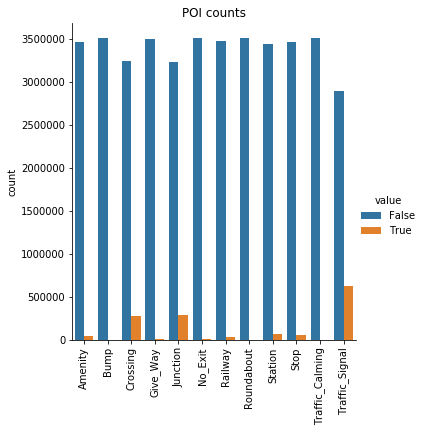

In [11]:
fg = sns.catplot(x="variable", y='count', hue="value", data=POI_count, kind='bar')
fg.set_xlabels('')
plt.title("POI counts")
plt.xticks(rotation=90)

# Create date and time

In [12]:
df[['Date', 'Time']] = df['Start_Time'].str.split(' ', 1, expand=True)

## Weather

In [13]:
df["Weather_Condition"].head()

0       Light Rain
1       Light Rain
2         Overcast
3    Mostly Cloudy
4    Mostly Cloudy
Name: Weather_Condition, dtype: object

In [16]:
weather_cond_df = pd.DataFrame(df.groupby("Weather_Condition").count()["ID"].sort_values(ascending=False)).head(75)

In [17]:
weather_cond_df[:10]

,ID
Weather_Condition,
Clear,808168
Fair,547691
Mostly Cloudy,488082
Overcast,382477
Partly Cloudy,344802
Cloudy,212873
Scattered Clouds,204653
Light Rain,176929
Light Snow,50433


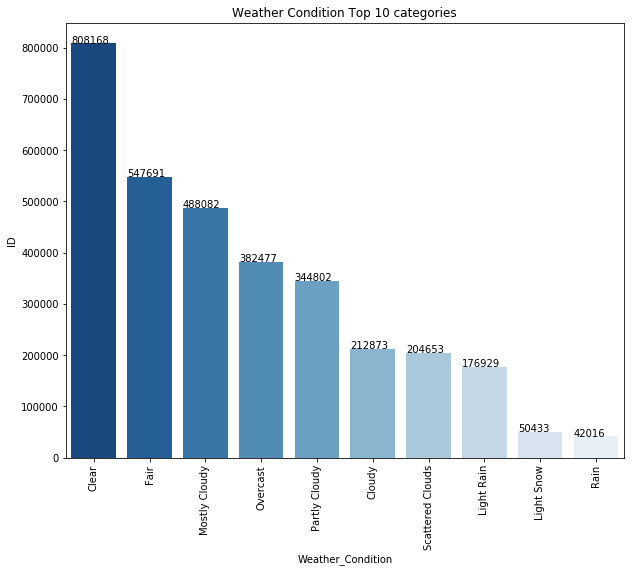

In [18]:
_ = plt.figure(figsize=(10,8))
_ = plt.title("Weather Condition Top 10 categories")
ax = sns.barplot(x=weather_cond_df.index[:10], y=weather_cond_df.ID[:10], palette="Blues_r")
_ = plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x(), p.get_height())
    )

In [19]:
WEATHER_COLS = [
    "Temperature(F)",
    "Wind_Chill(F)",
    "Humidity(%)",
    "Pressure(in)",
    "Visibility(mi)",
    "Wind_Direction",
    "Wind_Speed(mph)",
]

In [20]:
for w in WEATHER_COLS:
    print("{}\t{}\t{:.4f}".format(w, np.sum(df[w].isna()), np.sum(df[w].isna())/df.shape[0]))

Temperature(F)	0	0.0000
Wind_Chill(F)	0	0.0000
Humidity(%)	0	0.0000
Pressure(in)	0	0.0000
Visibility(mi)	0	0.0000
Wind_Direction	58873	0.0168
Wind_Speed(mph)	0	0.0000


In [21]:
df[WEATHER_COLS].describe()

,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph)
count,3.513480e+06,3.513480e+06,3.513480e+06,3.513480e+06,3.513480e+06,3.513480e+06
mean,6.197380e+01,5.538787e+01,6.515145e+01,2.974789e+01,9.141600e+00,8.061319e+00
std,1.844827e+01,1.635895e+01,2.253035e+01,8.257386e-01,2.857413e+00,4.927627e+00
min,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+01,5.700000e+01,4.900000e+01,2.974000e+01,1.000000e+01,5.000000e+00
50%,6.400000e+01,5.700000e+01,6.700000e+01,2.995000e+01,1.000000e+01,7.000000e+00
75%,7.570000e+01,5.700000e+01,8.400000e+01,3.009000e+01,1.000000e+01,1.040000e+01
max,1.706000e+02,1.150000e+02,1.000000e+02,5.774000e+01,1.400000e+02,9.840000e+02


In [38]:
df[WEATHER_COLS][df["Wind_Speed(mph)"] < 200].shape

(3058878, 7)

In [39]:
[w for w in WEATHER_COLS if w not in ['Temperature(F)', 'Wind_Chill(F)']]

['Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)']

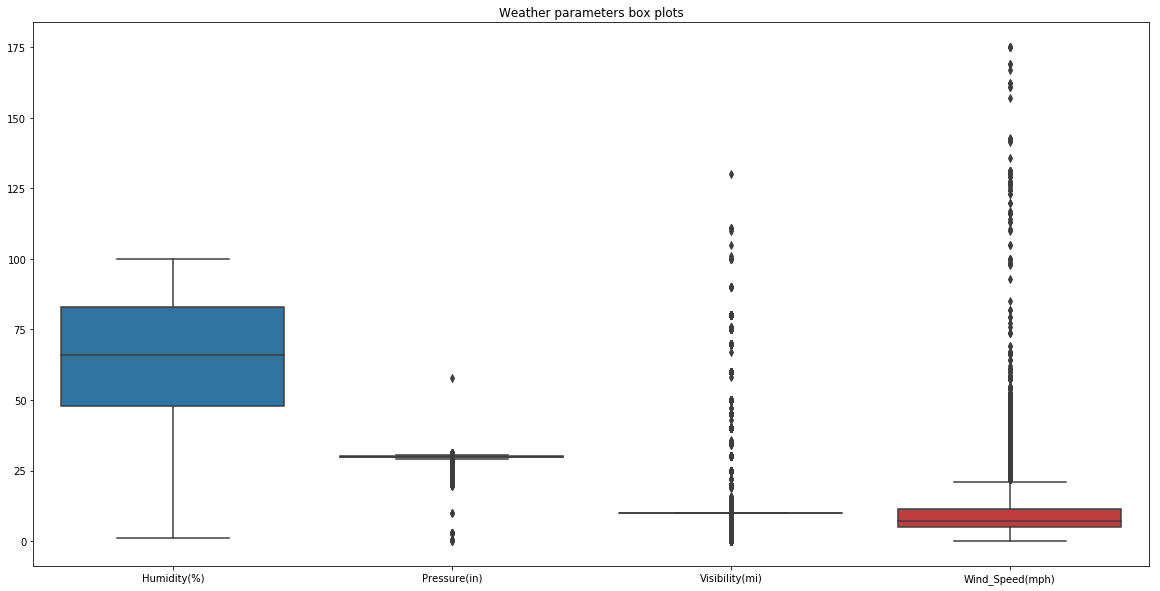

In [40]:
# create box plot
plt.figure(figsize=(20,10))
plt.title("Weather parameters box plots")
ax = sns.boxplot(data=df[[w for w in WEATHER_COLS if w not in ['Temperature(F)', 'Wind_Chill(F)']]][df["Wind_Speed(mph)"] < 200])

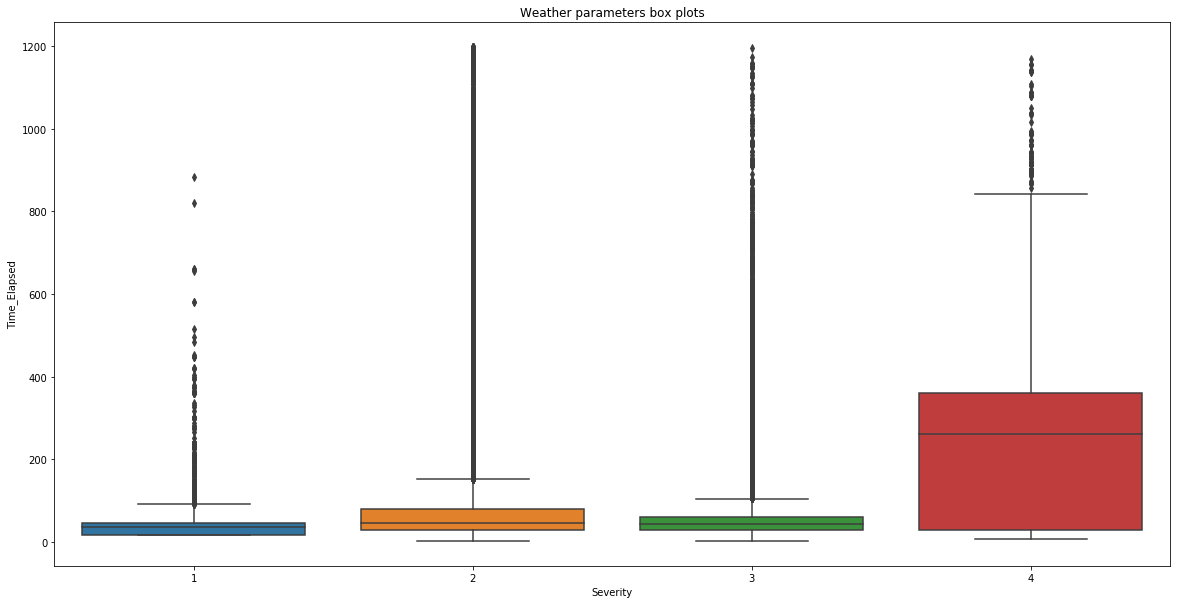

In [21]:
# create box plot
plt.figure(figsize=(20,10))
plt.title("Weather parameters box plots")
ax = sns.boxplot(x="Severity", y="Time_Elapsed", data=df[df["Time_Elapsed"] < 1200][["Time_Elapsed", "Severity"]])

In [24]:
pd.DataFrame(df.groupby(["region", "Traffic_Signal"]).count()["ID"]).to_csv("./output.csv")

In [22]:
df[df["Time_Elapsed"] >= 1200].shape

(2551, 39)

In [16]:
df["Time_Elapsed"].max()

1421955.0

In [41]:
df[df["Wind_Speed(mph)"] > 200].groupby("Severity").count()["ID"]

Severity
2    19
3     8
4     2
Name: ID, dtype: int64

In [42]:
df.columns

Index(['ID', 'TMC', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County',
       'State', 'Zipcode', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Date', 'Time'],
      dtype='object')

## Non-weather cause

In [43]:
df[~df["Weather_Condition"].isin(["Clear", "Fair"])].groupby("Severity").count()["ID"]

Severity
1      14857
2    1430901
3     643400
4      68472
Name: ID, dtype: int64

In [44]:
df[df["Weather_Condition"].isin(["Clear", "Fair"])].groupby("Severity").count()["ID"]

Severity
1     14314
2    942230
3    355500
4     43828
Name: ID, dtype: int64

In [45]:
df.groupby("Severity").count()["ID"]

Severity
1      29171
2    2373131
3     998900
4     112300
Name: ID, dtype: int64

## Distance (Mi)

In [46]:
df.groupby("Severity").describe()["Distance(mi)"]

,count,mean,std,min,25%,50%,75%,max
Severity,,,,,,,,
1,29171.0,0.195387,0.996080,0.0,0.0,0.000,0.000,24.603000
2,2373131.0,0.161265,0.973159,0.0,0.0,0.000,0.010,227.210007
3,998900.0,0.408344,2.080441,0.0,0.0,0.000,0.010,333.630005
4,112300.0,1.719525,3.727100,0.0,0.2,0.603,1.735,152.543000


<Figure size 1440x1440 with 0 Axes>

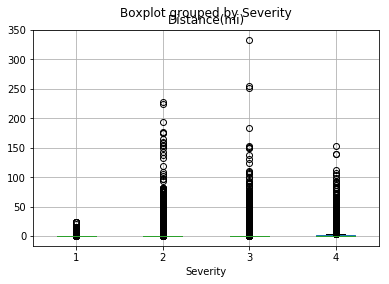

<Figure size 1440x1440 with 0 Axes>

In [47]:

df.boxplot(column=["Distance(mi)"], by="Severity")
plt.figure(figsize=(20, 20))

## US population vs automobiles

In [57]:
US_pop = {
    "AL": 4903185,"AK": 731545,
    "AZ": 7278717,"AR": 3017852,
    "CA": 39512223,"CO": 5758736,
    "CT": 3565287,
    "DE": 973764,"FL": 21477737,
    "GA": 10617423,"HI": 1415872,
    "ID": 1787065,"IL": 12671821,
    "IN": 6732219,"IA": 3155070,
    "KS": 2913314,"KY": 4467673,
    "LA": 4648794,
    "ME": 1344212,"MD": 6045680,
    "MA": 6949503,"MI": 9986857,
    "MN": 5639632,"MS": 2976149,
    "MO": 6137428,"MT": 1068778,
    "NE": 1934408,
    "NV": 3080156,"NH": 1359711,
    "NJ": 8882190,"NM": 1096829,
    "NY": 19453561,"NC": 10488084,
    "ND": 762062,"OH": 11689100,
    "OK": 3956971,"OR": 4217737,
    "PA": 12801989,"RI": 1059361,
    "SC": 5148714,"SD": 884659,
    "TN": 6833174,"TX": 28995881,
    "UT": 3205958,
    "VT":623989,"VA": 8535519,
    "WA": 8614893,"WV": 1792147,
    "WI": 5822434,
    "WY":578759,"DC":705749
}

In [58]:
US_cars = {
    "AL": 2161212,"AK": 731545,
 "AZ": 2391772,"AR": 921161,
 "CA": 15065827,"CO": 1798177,"CT": 1306709,
 "DE": 433363,"FL": 7966091,
 "GA": 3557469,"HI": 509492,
 "ID": 598774,"IL": 4477763,
 "IN": 2248870,"IA": 1242219,
 "KS": 975171,"KY": 1721942,"LA": 1389249,
 "ME": 390506,"MD": 1922463,
 "MA": 2182530,"MI": 3023940,
 "MN": 1976525,"MS": 825338,
 "MO": 2102216,"MT": 452845,"NE": 683020,
 "NV": 1073760,"NH": 506959,
 "NJ": 2754253,"NM": 655766,
 "NY": 4712779,"NC": 3393781,
 "ND": 240048,"OH": 4603594,
 "OK": 1296218,"OR": 1488623,
 "PA": 4424183,"RI": 412255,
 "SC": 1830186,"SD": 358859,
 "TN": 2285329,"TX": 8248322,"UT": 937421,
 "VT":218302,"VA": 3267735,
 "WA": 2964939,"WV": 560118,"WI": 2087518,
 "WY":203546,"DC":209723
}

In [65]:
ind = []
pop = []
car = []
for (key, item), (_, item2) in zip(US_pop.items(), US_cars.items()):
    ind.append(key)
    pop.append(item)
    car.append(item2)

pd.DataFrame({"population":num, "car":car}, index=ind).to_csv("./output.csv")

In [33]:
states = list(US_pop.keys())

In [34]:
count_df = df.groupby("State").count()["ID"]

In [35]:
count_df = pd.DataFrame(count_df)

In [36]:
cars = []
pop = []
for ind in count_df.index:
    cars.append(US_cars[ind])
    pop.append(US_pop[ind])

In [37]:
count_df["cars"] = cars
count_df["pop"] = pop

In [38]:
count_df["ratioByPop"] = count_df["ID"]/count_df["pop"]
count_df["ratioByCars"] = count_df["ID"]/count_df["cars"]
count_df["ratioPbyCars"] = count_df["pop"]/count_df["cars"]

In [39]:
count_df.sort_values("ratioByPop", ascending=False).head(10)

,ID,cars,pop,ratioByPop,ratioByCars,ratioPbyCars
State,,,,,,
SC,173277,1830186,5148714,0.033654,0.094677,2.813219
OR,90122,1488623,4217737,0.021367,0.060541,2.833314
CA,816804,15065827,39512223,0.020672,0.054216,2.622639
UT,51684,937421,3205958,0.016121,0.055134,3.419977
NC,165955,3393781,10488084,0.015823,0.048900,3.090383
OK,60003,1296218,3956971,0.015164,0.046291,3.052705
MN,81863,1976525,5639632,0.014516,0.041418,2.853307
LA,61515,1389249,4648794,0.013232,0.044279,3.346264
NE,23970,683020,1934408,0.012391,0.035094,2.832140


In [56]:
count_df.sort_values("ratioByPop", ascending=False)["ratioByPop"].iloc[:10].to_csv("./output.csv")

## Is highway?

In [75]:
param = "I-70 E"

In [76]:
def is_highway(street):
    s = street.split(" ")
    
    if "I-" in s[0]:
        return True
    if "Freeway" in s[-1]:
        return True
    if "US-" in s[0]:
        return True
    if s[-1].isnumeric():
        return True
    if "Highway" in s:
        return True
    if "Freeway" in s:
        return True
    if "Hwy" in s:
        return True
    if "Fwy" in s:
        return True
    if "Expy" in s:
        return True
    
    for st in states:
        if "{}-".format(st) in s[0]:
            return True
    return False

In [77]:
df["is_highway"] = df["Street"].apply(is_highway)

In [78]:
df["Time_Elapsed"] = (pd.to_datetime(df['End_Time'])-pd.to_datetime(df["Start_Time"])).astype('timedelta64[m]')

In [83]:
pd.DataFrame(df.groupby(["region", "is_highway"]).count()["ID"]).to_csv("./output.csv")

In [112]:
df["Time_Elapsed"].describe()

count    3.513502e+06
mean     1.148481e+02
std      3.380455e+03
min     -3.500000e+01
25%      2.900000e+01
50%      4.400000e+01
75%      7.400000e+01
max      1.421955e+06
Name: Time_Elapsed, dtype: float64

In [64]:
df.groupby("is_highway").count()["ID"]

is_highway
False    1823363
True     1690139
Name: ID, dtype: int64

In [ ]:
df["Start_Time"].cumsum()

## Create Region

In [66]:
US_region = {
    "northeast": ["CT", "ME", "MA", "NH", "RI", "VT", "NJ", "NY", "PA"],
    "midwest": ["IL", "IN", "MI", "TN", "IA", "KS", "MN", "OH", "MO", "NE", "ND", "SD", "WI"],
    "south" : ["DE", "FL", "GA", "MD", "NC", "SC", "VA", "DC", "WV", "AL", "KY", "MS", "TN", "AR", "LA", "OK", "TX"],
    "west" : ["AZ", "CO", "ID", "MT", "NV", "NM", "UT", "WY", "AK", "CA", "HI", "OR", "WA"]
}

In [67]:
def map_state(state):
    for key, items in US_region.items():
        if state in items:
            return key

In [68]:
map_state("OH")

'midwest'

In [69]:
df["State"].iloc[0]

'OH'

In [70]:
df["region"] = df["State"].apply(map_state)

In [71]:
df["region"].head()

0    midwest
1    midwest
2    midwest
3    midwest
4    midwest
Name: region, dtype: object

In [74]:
pd.DataFrame(df.groupby(["region", "Severity"]).count()["ID"]).to_csv("./output.csv")

In [109]:
df["region"].unique()

array(['midwest', 'south', 'west', 'northeast'], dtype=object)

## Create trends of accident

In [193]:
df["Date"].unique().shape

(1601,)

In [200]:
df["Year"] = df.apply(lambda x: x["Date"].split("-")[0], axis=1)
# df["Month"] = df.apply(lambda x: x["Date"].split("-")[1], axis=1)
# df["Day"] = df.apply(lambda x: x["Date"].split("-")[2], axis=1)

In [202]:
df[["Year", "Month", "Day"]].head()

,Year,Month,Day
0,2016,02,08
1,2016,02,08
2,2016,02,08
3,2016,02,08
4,2016,02,08


In [204]:
df[df["Year"] == "2020"].shape

(539158, 48)

In [ ]:
df[df["Year"] == "2020"].cumsum()

In [13]:
cols

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [ ]:
date

Base Features:
- ID
- TMC

Time&Location Related features:
- Start_Time
- End_Time
- Start_Lat
- Start_Lng

Address related features:
- Street
- City
- County
- State
- Zipcode

Q: WHat's distance from and to?
- Distance(mi)


Weather related features:
- Temperature(F)
- Wind_Chill(F)
- Humidity(%)
- Pressure(in)
- Visibility(mi)
- Wind_Direction
- Wind_Speed(mph)
- Weather_Condition

Road Related features:
- Amenity
- Bump
- Crossing
- Give_Way
- Junction
- No_Exit
- Railway
- Roundabout
- Station
- Stop
- Traffic_Calming
- Traffic_Signal

Astronomical Features:
- Sunrise_Sunset

In [66]:
df.groupby("Amenity").count()["ID"]

Amenity
False    3471423
True       42079
Name: ID, dtype: int64

In [67]:
df.groupby("Station").count()["ID"]

Station
False    3443181
True       70321
Name: ID, dtype: int64

In [65]:
df.groupby("Traffic_Calming").count()["ID"]

Traffic_Calming
False    3512101
True        1401
Name: ID, dtype: int64

In [24]:
df["Description"].iloc[2:20].values

array(['Accident on OH-32 State Route 32 Westbound at Dela Palma Rd. Expect delays.',
       'Accident on I-75 Southbound at Exits 52 52B US-35. Expect delays.',
       'Accident on McEwen Rd at OH-725 Miamisburg Centerville Rd. Expect delays.',
       'Accident on I-270 Outerbelt Northbound near Exit 29 OH-3 State St. Expect delays.',
       'Accident on Oakridge Dr at Woodward Ave. Expect delays.',
       'Accident on I-75 Southbound at Exit 54B Grand Ave. Expect delays.',
       'Accident on Notre Dame Ave at Warner Ave. Expect delays.',
       'Right hand shoulder blocked due to accident on I-270 Outerbelt Westbound at Exit 29 OH-3 State St.',
       'Accident on I-270 Outerbelt Northbound at Exits 7 7A 7B US-40 Broad St. Expect delays.',
       'One lane blocked due to accident on I-70 Westbound at Exits 110 110A 110B Brice Rd. Expect delays.',
       'Accident on Revere Ave at Watervliet Ave. Expect delays.',
       'Accident on Salem Ave at Hillcrest Ave / Kensington Dr. Expect 

In [15]:
df["Give_Way"].unique()

array([False,  True])

In [6]:
len(df.columns)

49

In [7]:
df.describe()

,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,2.478818e+06,3.513617e+06,3.513617e+06,3.513617e+06,1.034799e+06,1.034799e+06,3.513617e+06,1.250753e+06,3.447885e+06,1.645368e+06,3.443930e+06,3.457735e+06,3.437761e+06,3.059008e+06,1.487743e+06
mean,2.080226e+02,2.339929e+00,3.654195e+01,-9.579151e+01,3.755758e+01,-1.004560e+02,2.816167e-01,5.975383e+03,6.193512e+01,5.355730e+01,6.511427e+01,2.974463e+01,9.122644e+00,8.219025e+00,1.598256e-02
std,2.076627e+01,5.521935e-01,4.883520e+00,1.736877e+01,4.861215e+00,1.852879e+01,1.550134e+00,1.496624e+04,1.862106e+01,2.377334e+01,2.275558e+01,8.319758e-01,2.885879e+00,5.262847e+00,1.928262e-01
min,2.000000e+02,1.000000e+00,2.455527e+01,-1.246238e+02,2.457011e+01,-1.244978e+02,0.000000e+00,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.010000e+02,2.000000e+00,3.363784e+01,-1.174418e+02,3.399477e+01,-1.183440e+02,0.000000e+00,8.640000e+02,5.000000e+01,3.570000e+01,4.800000e+01,2.973000e+01,1.000000e+01,5.000000e+00,0.000000e+00
50%,2.010000e+02,2.000000e+00,3.591687e+01,-9.102601e+01,3.779736e+01,-9.703438e+01,0.000000e+00,2.798000e+03,6.400000e+01,5.700000e+01,6.700000e+01,2.995000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.010000e+02,3.000000e+00,4.032217e+01,-8.093299e+01,4.105139e+01,-8.210168e+01,1.000000e-02,7.098000e+03,7.590000e+01,7.200000e+01,8.400000e+01,3.009000e+01,1.000000e+01,1.150000e+01,0.000000e+00
max,4.060000e+02,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,3.336300e+02,9.999997e+06,1.706000e+02,1.150000e+02,1.000000e+02,5.774000e+01,1.400000e+02,9.840000e+02,2.500000e+01


In [8]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [11]:
df["Start_Lng"].unique().shape

(1113407,)